In [1]:
%env CUDA_VISIBLE_DEVICES=2
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
from flax import linen as nn
import optax
jax.devices()

env: CUDA_VISIBLE_DEVICES=2
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


[cuda(id=0)]

# data

(3,) (1024, 1) (1024, 1)


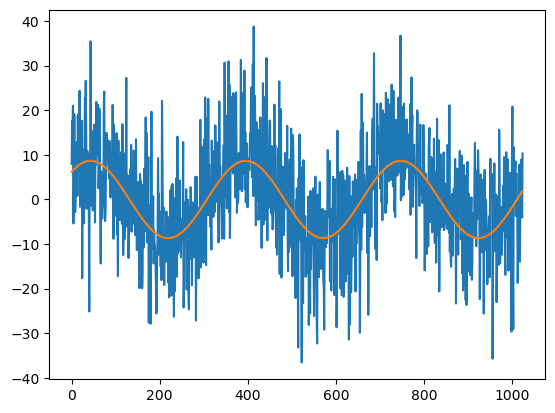

In [2]:
class SinusoidDataset(eqx.Module):
    n_sources: int = 1
    A_range: tuple[float, float] = (1e0, 1e1)
    omega_range: tuple[float, float] = (1e-2, 1e-1)
    phi_range: tuple[float, float] = (0.0, jnp.pi)
    dual_channel: bool = False

    observation_time: float = 1024.0
    sampling_rate: float = 1.0 
    white_noise_std: float = 1e1

    @property
    def observation_times(self):
        return np.arange(0.0, self.observation_time, self.sampling_rate)

    def clean_signal(self, A, omega, phi):
        t = self.observation_times[:, None]
        h1 = (A * jnp.sin(omega * t + phi)).sum(axis=-1, keepdims=True)
        if not self.dual_channel:
            return h1
        h2 = (A * jnp.cos(omega * t + phi)).sum(axis=-1, keepdims=True)
        return jnp.concatenate([h1, h2], axis=-1)

    def datastream(self, key, clean_signal):
        noise = self.white_noise_std * jr.normal(key, clean_signal.shape)
        return clean_signal + noise

    def log_likelihood(self, params, datastream):
        A, omega, phi = params
        delta = datastream - self.clean_signal(A, omega, phi)
        return -0.5 * jnp.sum(delta**2) / self.white_noise_std**2

    def sample_params(self, key):
        key_A, key_omega, key_phi = jr.split(key, 3)
        log_A_min, log_A_max = (jnp.log10(el) for el in self.A_range)
        log_omega_min, log_omega_max = (jnp.log10(el) for el in self.omega_range)
        phi_min, phi_max = self.phi_range

        log_A = jr.uniform(key_A, minval=log_A_min, maxval=log_A_max)
        log_omega = jr.uniform(key_omega, minval=log_omega_min, maxval=log_omega_max)
        phi = jr.uniform(key_phi, minval=phi_min, maxval=phi_max)

        return 10**log_A, 10**log_omega, phi

    def get_item(self, key):
        key_t, key_params, key_data = jr.split(key, 3)
        params = jax.vmap(self.sample_params)(jr.split(key_params, self.n_sources))
        clean = self.clean_signal(*params)
        noisy = self.datastream(key_data, clean)
        return jnp.concatenate(params, -1), clean, noisy

    def get_batch(self, key, batch_size):
        return jax.vmap(self.get_item)(jr.split(key, batch_size))


dataset = SinusoidDataset(n_sources=1, dual_channel=False)
params, clean, noisy = dataset.get_item(jr.key(0))
plt.plot(noisy)
plt.plot(clean)
print(params.shape, clean.shape, noisy.shape)

# model

In [3]:
from models import TimeEmbed, ParamEmbed, ZeroInitDense, AdaLayerNorm, FCBlock

class CNF(nn.Module):
    dim: int
    depth: int = 4
    coupling_sigma: float = 1e-8

    def modulation(self, x):
        x = nn.Dense(x.shape[-1])(x)
        x = nn.silu(x)
        x = ZeroInitDense(x.shape[-1] * 3)(x)
        return jnp.split(x[..., :], 3, axis=-1)

    @nn.compact
    def __call__(self, t, x, d):
        c = TimeEmbed(self.dim)(t) + ParamEmbed(self.dim)(x)
        h = d.reshape((*d.shape[:-2], -1)) 
        h = nn.Dense(self.dim)(h)
        for _ in range(self.depth):
            scale, shift, gate = self.modulation(c)
            h = h + gate*FCBlock()(AdaLayerNorm()(h, scale, shift))
        h = nn.Dense(2*x.shape[-1])(h)
        h, recon = jnp.split(h, 2, axis=-1)
        return h, recon

    def push(self, x0, d, n_steps=32):
        xt, dt = [x0], 1 / n_steps
        d = jnp.tile(d, (x0.shape[0], *(1 for _ in d.shape)))
        for t in jnp.arange(0, 1, 1 / n_steps):
            t = t * jnp.ones((x0.shape[0],))
            flow, recon = self(t, xt[-1], d)
            xt.append(xt[-1] + dt * flow)
        return jnp.stack(xt, axis=0)

    def loss(self, key, batch):
        t, x0, x1, d = batch
        target_flow = x1 - x0

        xt_mean = t[..., None] * x1 + (1 - t[..., None]) * x0
        z = jr.normal(key, xt_mean.shape[:-1])[..., None]
        xt = xt_mean + z * self.coupling_sigma

        flow, recon = self(t, xt, d)
        flow_loss = jnp.mean(optax.l2_loss(flow, target_flow))
        recon_loss = jnp.mean(optax.l2_loss(recon, x1))
        return flow_loss + 0.001 * recon_loss

# train

In [4]:
from typing import Callable

class Trainer(eqx.Module):
    model: nn.Module
    get_batch_fn: Callable
    optimizer: optax.GradientTransformation
    epochs: int
    epoch_steps: int
    batch_size: int

    def init_state(self, key):
        batch = self.get_batch_fn(key, self.batch_size)
        params = self.model.init(key, key, batch, method='loss')
        opt_state = self.optimizer.init(params)
        return (params, opt_state)

    def train_step(self, state, key):
        params, opt_state = state
        key_batch, key_loss = jr.split(key)
        batch = self.get_batch_fn(key_batch, self.batch_size)

        loss_fn = lambda par: self.model.apply(par, key_loss, batch, method='loss')
        loss, grads = jax.value_and_grad(loss_fn)(params)

        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), loss

    @eqx.filter_jit
    def train_epoch(self, state, key):
        keys = jr.split(key, self.epoch_steps)
        state, losses = jax.lax.scan(self.train_step, state, keys)
        return state, losses

    def fit(self, key, state=None):
        key_init, *keys_epochs = jr.split(key, self.epochs+1)
        (params, opt_state) = state or self.init_state(key_init)
        log = []
        for key in (pbar := tqdm(keys_epochs)):
            (params, opt_state), losses = self.train_epoch((params, opt_state), key)
            pbar.set_postfix(loss=losses.mean())
            log.append(float(losses.mean()))
        log = jnp.array(log)
        return self.model.bind(params), params, opt_state, log

In [5]:
def get_flow_matching_batch(key, batch_size):
    key_t, key_x0, key_x1 = jr.split(key, 3)
    t = jax.nn.sigmoid(jr.normal(key_t, (batch_size,)))
    params_x0, clean_x0, data_x0 = dataset.get_batch(key_x0, batch_size)
    params_x1, clean_x1, data_x1 = dataset.get_batch(key_x1, batch_size)

    # flow in log space
    x0 = params_x0.at[:, :2].set(jnp.log10(params_x0[:, :2]))
    x1 = params_x1.at[:, :2].set(jnp.log10(params_x1[:, :2]))     
    return t, x0, x1, data_x1

trainer = Trainer(  
    model=CNF(256, coupling_sigma=0.0001),
    get_batch_fn=get_flow_matching_batch,
    optimizer=optax.adam(1e-4),
    epochs=100,
    epoch_steps=128,
    batch_size=1024,
)

100%|██████████| 100/100 [00:32<00:00,  3.07it/s, loss=0.14214942]


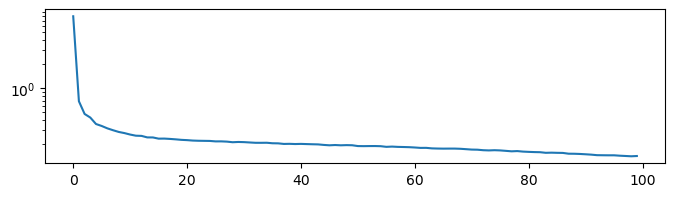

In [6]:
flow, params, opt_state, losses = trainer.fit(jr.key(0))
plt.figure(figsize=(8, 2))
plt.semilogy(losses)
plt.show()

# results

In [7]:
import emcee

def Hessian(theta_max, t, sigma):
    [A, w, phi] = theta_max
    arg = w * t + phi
    cos = np.cos(arg)
    sin = np.sin(arg)

    H11 = 1 / sigma**2 * np.sum(sin**2)
    H22 = 1 / sigma**2 * A**2 * np.sum(t**2 * cos**2)
    H33 = 1 / sigma**2 * A**2 * np.sum(cos**2)
    H12 = 1 / sigma**2 * A * np.sum(t * cos * sin)
    H13 = 1 / sigma**2 * A * np.sum(cos * sin)
    H23 = 1 / sigma**2 * A**2 * np.sum(t * cos**2)
    H = np.array([[H11, H12, H13], [H12, H22, H23], [H13, H23, H33]])
    return H


##########################################################   # Per la postirior di MCMC:

def emcee_sampler(log_post, x0, nburn=300, steps=10000, **kwargs):  # Funzione MCMC 1
    mnwalkers, mndim = x0.shape
    sampler = emcee.EnsembleSampler(mnwalkers, mndim, log_post)
    sampler.run_mcmc(x0, nburn, progress=False, tune=True)
    state = sampler.get_chain()[-1, :, :]
    sampler.reset()
    # print('Finished initial run, burn-in dropped and starting real run')
    sampler.run_mcmc(state, steps, progress=False, tune=True)
    return sampler.get_log_prob(), sampler.get_chain()


def big_sampler(n_samples, log_posterior, theta0, nburn=300):
    ndim = len(theta0)
    nwalkers = 8 * ndim
    steps = int(np.ceil(n_samples / nwalkers))
    p0 = np.zeros((nwalkers, ndim))
    for i in range(nwalkers):
        p0[i] = theta0 * np.random.normal(loc=1.0, scale=0.001, size=ndim)
    log_prob, chain = emcee_sampler(log_posterior, p0, nburn=nburn, steps=steps)
    return chain.reshape(-1, ndim)[-n_samples:, :]

In [8]:
import corner

for k in range(2):
    t, x0, x1, d = trainer.get_batch_fn(jr.key(42), 8*1024)
    true_params, datastream = np.array(x1[0]), d[0]
    true_params[:2] = 10 ** true_params[:2]
    params_max = np.array(true_params)
    true_params[:2] = np.log10(true_params[:2])

    # sample from prior
    x1_prior = np.array(x0)
    dx = np.random.randn(*x1_prior.shape) * 1e-8
    # x1_prior[:, :2] = 10 ** x1_prior[:, :2]
    # x1_prior[:, :2] = np.log10(x1_prior[:, :2])

    # sample using CNF
    print("SAMPLING USING CNF")
    xt = flow.push(x0, datastream, n_steps=64)
    x1_cnf = np.array(xt[-1])
    # x1_cnf[:, :2] = 10 ** x1_cnf[:, :2]
    # x1_cnf[:, :2] = np.log10(x1_cnf[:, :2])

    # sample using FISHER
    print("SAMPLING USING FISHER")
    cov = np.linalg.inv(Hessian(params_max, dataset.observation_times, dataset.white_noise_std))
    x1_fisher = np.random.multivariate_normal(params_max, 1 / 2 * cov, len(x1_cnf))
    # x1_fisher[:, :2] = 10 ** x1_fisher[:, :2]
    x1_fisher[:, :2] = np.log10(x1_fisher[:, :2])

    # sample using MCMC
    print("SAMPLING USING MCMC")
    log_posterior = lambda p: dataset.log_likelihood(p, datastream)
    x1_mcmc = big_sampler(len(x1_cnf), log_posterior, theta0=params_max)
    x1_mcmc = x1_mcmc[1].reshape(-1, 3)[-len(x1_cnf) :, :]
    x1_mcmc[:, :2] = np.log10(x1_mcmc[:, :2])

    # plot corner
    corner_kwargs = dict(
        labels=["A", "omega", "phi"], show_titles=True, truths=true_params
    )
    fig = corner.corner(x1_prior + dx, color="black", **corner_kwargs)
    fig = corner.corner(x1_cnf + dx, color="blue", **corner_kwargs, fig=fig)
    fig = corner.corner(x1_fisher + dx, color="green", **corner_kwargs, fig=fig)
    fig = corner.corner(x1_mcmc + dx, color="red", **corner_kwargs, fig=fig)

/tmp/ipykernel_3145003/3182145697.py:8: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x1_fisher_jax = np.random.multivariate_normal(params_max, 1 / 2 * cov, len(x1_cnf))


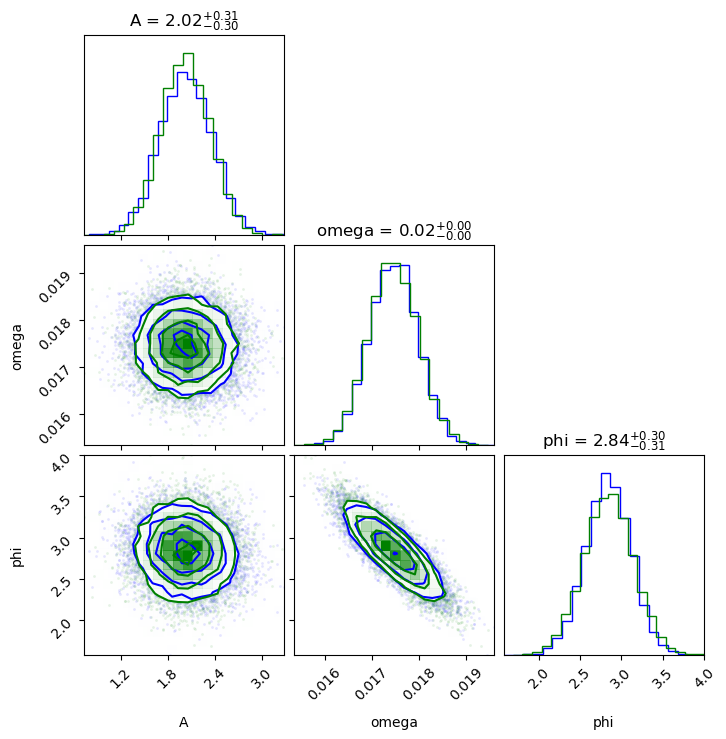

In [11]:
# sample using FISHER
cov = np.linalg.inv(Hessian(params_max, dataset.observation_times, dataset.white_noise_std))
x1_fisher = np.random.multivariate_normal(params_max, 1 / 2 * cov, len(x1_cnf))
    
# sample using jaxFISHER
Hessian_jax = jax.hessian(lambda p: dataset.log_likelihood(p, datastream))
cov = np.linalg.inv(Hessian_jax(params_max))
x1_fisher_jax = np.random.multivariate_normal(params_max, 1 / 2 * cov, len(x1_cnf))

# plot corner
corner_kwargs = dict(labels=["A", "omega", "phi"], show_titles=True)
fig = corner.corner(x1_fisher_jax + dx, color="blue", **corner_kwargs)
fig = corner.corner(x1_fisher + dx, color="green", **corner_kwargs, fig=fig)